### Use this markdown to generate the predictors


In [ ]:
#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
reviews = pd.read_csv('train_app_review.csv')
ratings = pd.read_csv('train_app_rating.csv')
usages = pd.read_csv('train_usage.csv')
revenues = pd.read_csv('train_revenue.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

sentiment = pd.read_csv('sentiment.csv',header=-1).ix[:,0]
sentiment.values[sentiment.values==0.0] = 0.5
reviews["sentiment_score"] = sentiment.values 

#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

#Minor corrections
ratings = ratings.rename(columns={'start1': 'star1'})
ratings = pd.merge(downloads.drop(dateRange,1), ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category"]).replace("NaN",replacementValue)

#### Initialize the predictors matrix

In [ ]:
predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"]],
                       axis=1,keys=["id","name","category","device"])
predictors.head()

#### Use the train_app_downloads.csv file

In [ ]:
#Generate the logWeekly average
def generator_weekAvg(inp,w):
    if (np.count_nonzero(inp[5+w*7:12+w*7] - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))) == 0):
        return 0
    return  math.log(1.0*sum(inp[5+w*7:12+w*7])/np.count_nonzero(inp[5+w*7:12+w*7] 
                                                                 - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))))

for w in range(8):
    predictors["week_"+str(w+1)] = downloads.apply(generator_weekAvg,axis=1,args=(w,))

In [ ]:
#Generate the daily average
def generator_dailyAvg(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return  (1.0*sum(inp[5:])/np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))))
    #return  math.log(1.0*sum(inp[5:])/len(inp[5:]))

predictors["daily_avg"] = downloads.apply(generator_dailyAvg,axis=1)
#This one is bad

In [ ]:
#Generate the polynomial coefficients
def generator_coef(inp, coef):
    return  np.polyfit(range(56),inp[5:],coef)[0]
#Redo by ignoring the -1 / 0 ? w = [1110011]     w = np.not_equal(inp[5:],np.ones(len(inp[5:]))*replacementValue

for c in range(4):
    predictors["coef_"+str(c)] = downloads.apply(generator_coef,axis=1,args=(c,))

In [ ]:
#Generate the step max and min (we ignore the values of 0)
def generator_maxStep(inp,maximum):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    m = 0
    for d in range(1,56):
        if (inp[5+d]!=replacementValue and inp[4+d]!=replacementValue):
            c = (inp[5+d]-inp[4+d])
            if (maximum and m < c):
                m = c
            if ( not maximum and m > c):
                m = c
    return m
                
predictors["maxStep"] = downloads.apply(generator_maxStep,axis=1,args=(True,))
predictors["minStep"] = downloads.apply(generator_maxStep,axis=1,args=(False,))

In [ ]:
#Standard Deviation
def generator_std(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return np.std(inp[5:])

predictors["std"] = downloads.apply(generator_std,axis = 1)

In [ ]:
#Number of missing Values
def generator_missing(inp):
    return list(inp[5:]).count(replacementValue)
    #return np.count_zero(inp[5:] -replacementValue*np.ones(len(inp[5:])))

predictors["nb_missing"] = downloads.apply(generator_missing,axis = 1)

In [ ]:
#device
def generator_iphone(inp):
    if (inp[4] == "iphone"):
        return 1
    else:
        return 0

def generator_ipad(inp):
    if(inp[4] == "ipad"):
        return 1
    else:
        return 0
    
predictors["iphone"] = downloads.apply(generator_iphone,axis = 1)
predictors["ipad"] = downloads.apply(generator_ipad,axis = 1)

In [ ]:
#Categories
def generator_categories(inp,cat):
    if (inp[3] == cat):
        return 1
    else:
        return 0
    

for cat in list(set(downloads["category"])):
    predictors[cat] = downloads.apply(generator_categories,axis = 1,args=(cat,))

#### Use the train_app_rating.csv file

In [ ]:
avg_reviews = reviews.groupby('id').agg('mean')
avg_reviews['rating']
predictors['avg_review'] = predictors.join(avg_reviews['rating'],on='id')['rating'].replace("NaN",0)

In [ ]:
avg_reviews = reviews.groupby('id').agg('var')
avg_reviews['rating']
predictors['var_review'] = predictors.join(avg_reviews['rating'],on='id')['rating'].replace("NaN",0)

In [ ]:
#raw ratings
predictors = pd.merge(predictors, ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category","device"]).replace("NaN",replacementValue)

#### Use the sentiment score

In [ ]:
#Later we can compute the weighted average of sentiment scores based on reviewers.
#add positive and negative columns to indicate the app's popularity
print reviews.ix[id==predictors.id[0],:]["sentiment_score"]
print reviews.ix[id==predictors.id[1],:]["sentiment_score"]
avg_score = [0]*predictors.shape[0]
predictors["positive"] = [0]*predictors.shape[0]
predictors["negative"] = [0]*predictors.shape[0]
for i in range(predictors.shape[0]):
    avg_score[i] = reviews.ix[reviews["id"]==predictors.id[i],:]["sentiment_score"].mean()
    if avg_score[i]>0.55: 
        predictors["positive"].values[i] = 1
    elif avg_score[i]<0.45: predictors["negative"].values[i] = 1
#predictors["avg_sentiment_score"] = avg_score

 

#### Use coeficients of metrics 

In [ ]:
for i in range(4):
    predictors["m"+str(i+1)+"_max"] = np.zeros(predictors.shape[0]) 
    predictors["m"+str(i+1)+"_min"] = np.zeros(predictors.shape[0])
    predictors["m"+str(i+1)+"_mean"] = np.zeros(predictors.shape[0])
    predictors["m"+str(i+1)+"_std"] = np.zeros(predictors.shape[0])
    for j in range(3):
        predictors["m"+str(i+1)+"_coef_"+str(j)] = np.zeros(predictors.shape[0])

for i in range(predictors.shape[0]):
    if predictors["id"].values[i] not in usages["id"].values: continue
    for j in range(4):
        tmp = usages.ix[usages["id"] == predictors["id"].values[i],:]
        time_series = np.array(tmp.ix[tmp["metric"] == j+1,6:14])[0]   
        if -1 in time_series: continue
        X = np.array(range(8))
        fit = np.polyfit(X,time_series,2)
        for k in range(3):
            predictors["m"+str(j+1)+"_coef_"+str(k)].values[i] = fit[2-k]


In [ ]:
print predictors.columns

#### Use coeficients of revenue

In [ ]:
for j in range(3):
    predictors["rev_coef_"+str(j)] = np.zeros(predictors.shape[0])
    predictors["rev_max"] = np.zeros(predictors.shape[0])
    predictors["rev_min"] = np.zeros(predictors.shape[0])
    predictors["rev_mean"] = np.zeros(predictors.shape[0])
    predictors["rev_std"] = np.zeros(predictors.shape[0])
for i in range(predictors.shape[0]):
    
    if predictors["id"].values[i] in revenues["id"].values: 
        curr_rev  = revenues.ix[revenues["id"]== predictors["id"].values[i],:]
        if predictors["device"].values[i] in curr_rev["device"].values:
            curr_rev = curr_rev.ix[curr_rev["device"] == predictors["device"].values[i],:]
            time_series = np.array(curr_rev.ix[:,5:61])[0]
            if -1 in time_series: continue 
            X = np.array(range(56))
            fit = np.polyfit(X,time_series,2)
            for k in range(3):  predictors["rev_coef_"+str(k)].values[i] = fit[2-k]            

## To csv



In [ ]:
predictors.to_csv("predictors.csv")

In [ ]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)

In [ ]:
predictors.columns

## How good did the predictor perform   --> Start running from here

In [1]:
#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
reviews = pd.read_csv('train_app_review.csv')
ratings = pd.read_csv('train_app_rating.csv')
usages = pd.read_csv('train_usage.csv')
revenues = pd.read_csv('train_revenue.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

sentiment = pd.read_csv('sentiment.csv',header=-1).ix[:,0]
sentiment.values[sentiment.values==0.0] = 0.5
reviews["sentiment_score"] = sentiment.values 

#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

#Minor corrections
ratings = ratings.rename(columns={'start1': 'star1'})
ratings = pd.merge(downloads.drop(dateRange,1), ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category"]).replace("NaN",replacementValue)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#This is the metric we use to determine our performance
def metric(y_pred,y_test,percent=1):
    top = int(len(y_pred)/100.0*percent)
    return (len(set([i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)][0:top])
       .intersection([i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)][0:top])
               ))/(percent/100.0)/len(y_pred)*100

## Predictor selection

In [7]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)

In [4]:
#Use a model to do a forward recursive predictor selection
#mod=linear_model.Lasso(alpha=100,fit_intercept=False)
mod=linear_model.LinearRegression(fit_intercept=False)
#mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
#mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100) 
rfe = RFE(estimator=mod, n_features_to_select=1, step=1)
rfe.fit(predictors.as_matrix()[:,4:], output.as_matrix()[:,5])
ranking = rfe.ranking_

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
#manually drop predictors 
#predictors_to_drop = []
nb_pred_to_keep = 50
predictors_to_drop = [i[0] for i in sorted(zip(predictors.columns[4:],ranking),key=lambda x: x[1])[nb_pred_to_keep:]]
for col in predictors_to_drop:
    predictors = predictors.drop(col,1)
    

In [5]:
for e in sorted(zip(predictors.columns[4:],ranking),key=lambda x: x[1]):
    print e
print 'ok'

('m1_coef_2', 1)
('m2_coef_2', 2)
('m2_coef_1', 3)
('m1_coef_1', 4)
('m2_coef_0', 5)
('coef_3', 6)
('Shopping', 7)
('iphone', 8)
('Photo and Video', 9)
('Utilities', 10)
('Entertainment', 11)
('ipad', 12)
('week_1', 13)
('Social Networking', 14)
('Catalogs', 15)
('week_8', 16)
('Medical', 17)
('Weather', 18)
('Navigation', 19)
('News', 20)
('Business', 21)
('Books', 22)
('Food and Drink', 23)
('Reference', 24)
('Sports', 25)
('positive', 26)
('week_2', 27)
('Lifestyle', 28)
('Productivity', 29)
('m3_coef_2', 30)
('m3_coef_1', 31)
('week_4', 32)
('Music', 33)
('week_7', 34)
('week_3', 35)
('Finance', 36)
('week_6', 37)
('Travel', 38)
('m1_coef_0', 39)
('week_5', 40)
('Newsstand', 41)
('Education', 42)
('negative', 43)
('Health and Fitness', 44)
('nb_missing', 45)
('rev_coef_2', 46)
('var_review', 47)
('coef_1', 48)
('avg_review', 49)
('coef_2', 50)
('m3_coef_0', 51)
('Games', 52)
('coef_0', 53)
('rev_coef_1', 54)
('std', 55)
('minStep', 56)
('rev_coef_0', 57)
('m4_coef_2', 58)
('star3',

In [ ]:
old_top = []
new_top = []

test_frac = 0.31  #Fraction of test points
N = 20   #number of iterations
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:12], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    old_y_pred =  old_mod.predict(X_test)
    old_top.append(metric(old_y_pred,y_test))
    
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(X_train,y_train)
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(X_train,y_train)
    mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(X_train,y_train)
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test))
if (N<300):
    fig = plt.figure()
    plt.plot(range(1,N),old_top,label="old")
    plt.plot(range(1,N),new_top,label="performance")
    plt.legend(loc='best')
    plt.show()

print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

54.8947368421  
55.0526315789  #with #missing and Lasso <br/>
54.7894736842  #including raw ratings Lasso :( <br/>
55.0526315789  #with #missing weightedSumRatings and Lasso <br/>
55.1052631579  #adding the categories <br/>
55.3684210526  #adding average sentiment score and positive/negative label <br/>
55.5263157895  #adding coeficients of usages


With 10000 only:
54.8947368421 all

56.5263157895 on Lasso all but 'rev_coef_i'

Lasso All alpha = 100
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2']
57.1052631579

Predictor selection, pick the top 50 features selected in the forward recursive selection with Lasso and then do random forest

54.6842105263
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'avg_review', 'var_review', 'star2', 'star3', 'star4', 'positive', 'negative', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'm4_coef_2']
57.3157894737

In [ ]:
#Estimation of alpha for the Lasso regression "cros validation" like approach
for a in np.arange(90,110,5):

    old_top = []
    new_top = []

    test_frac = 0.31  #Fraction of test points
    N = 20   #number of iterations


    np.random.seed(1)
    for i in range(1,N):
        r = np.random.randint(1,429496729)
        X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
        X_test = X_test[0:10000]
        y_test = y_test[0:10000]
        mod=linear_model.Lasso(alpha=a,fit_intercept=False).fit(X_train,y_train) 
        y_pred =  mod.predict(X_test)
        new_top.append(metric(y_pred,y_test))


    print a
    print 1.0*sum(new_top)/len(new_top)
    print " "

## Cross Validation k-folds

In [89]:
K = 10

kf = KFold(len(predictors), n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #base model
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
    old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
    #model
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric(y_pred,output.as_matrix()[test,5]))
print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


6.1919504644
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_max', 'm1_min', 'm1_mean', 'm1_std', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_max', 'm2_min', 'm2_mean', 'm2_std', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_max', 'm3_min', 'm3_mean', 'm3_std', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_max', 'm4_min', 'm4_mean', 'm4_std', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_coef_0', 'rev_max'

K=10 
Random Forest sqrt  :mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
PPredictors obtainned with top 50 on Lasso
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star2', 'star3', 'star4', 'positive', 'negative', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'rev_coef_0', 'rev_coef_1']
58.1337784952

# Lasso all
53.4375
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2']
54.0625

## Attempt at boosting

In [ ]:
#Boosting

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

new_top = []

test_frac = 0.31  #Fraction of test points
N = 20   #number of iterations



np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    #mod=linear_model.Lasso(alpha=a,fit_intercept=False).fit(X_train,y_train) 
    mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(X_train,y_train)
    mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test))

print 1.0*sum(new_top)/len(new_top)
print " "


In [55]:
output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False).head(1)


,Unnamed: 0,id,name,category,device,cumulative_downloads_2016-02,scaled_downloads
29477,29477,911686788,"百度外卖-美食,优惠,水果生鲜,鲜花蛋糕,超市购",Food and Drink,iphone,12329752,1.874403e+07


In [ ]:
predictors.columns


# Making Classification on top 10%

In [88]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)

thr = predictors.sort_values(by= 'week_8',ascending = False).iloc[int(0.1*len(predictors))]["week_8"]
predictors  = predictors[predictors.week_8 >= thr]


len(predictors)

3234

Series([], Name: week_8, dtype: float64)

In [243]:
output_classification_10 = output
output_classification_50 = output
output_classification_100 = output
#Is top ?
def generator_istop(inp,threshold):
    if (inp[5] >= threshold):
        return 'True'
    else:
        return 'False'

threshold = output.sort_values('cumulative_downloads_2016-02',ascending = False).iloc[len(output)/10]['cumulative_downloads_2016-02']
output_classification_10["is_top"] = output.apply(generator_istop,axis = 1,args=(threshold,))

threshold = output.sort_values('cumulative_downloads_2016-02',ascending = False).iloc[len(output)/50]['cumulative_downloads_2016-02']
output_classification_50["is_top"] = output.apply(generator_istop,axis = 1,args=(threshold,))

threshold = output.sort_values('cumulative_downloads_2016-02',ascending = False).iloc[len(output)/100]['cumulative_downloads_2016-02']
output_classification_100["is_top"] = output.apply(generator_istop,axis = 1,args=(threshold,))

In [244]:
output_classification_10.head()

,Unnamed: 0,id,name,category,device,cumulative_downloads_2016-02,is_top
0,0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,753496,False
1,1,281922769,Mobile MIM,Medical,ipad,100804,False
2,2,281922769,Mobile MIM,Medical,iphone,111613,False
3,3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,370383,False
4,4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,1330247,False


In [ ]:
from sklearn.svm import SVC
K=10
kf = KFold(32339, n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #model
    mod = SVC(C=10.0, kernel='poly', degree=3, gamma='auto', coef0=2.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=10, decision_function_shape=None, random_state=None).fit(predictors.as_matrix()[train,4:],output_classification_10.as_matrix()[train,6])
    #mod = linear_model.LogisticRegression().fit(predictors.as_matrix()[train,4:], output_classification_10.as_matrix()[train,6])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric_classification(y_pred,output_classification_10.as_matrix()[test,6]))
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)


In [248]:
###This metric is not very good, put True everywhere and get 100%
def metric_classification(y_pred,y_test):
    nb_top = 0
    for i in range(len(y_test)):
        if (y_pred[i]=='True' and y_test[i]=="False"):
            nb_top+=1
    return 100.0*nb_top/len(y_pred)


In [272]:
list(y_pred).count("False")*1.0/len(y_pred)

0.009279307145066501

In [ ]:
print list(y_pred).count('True')
print list(output_classification_10.as_matrix()[test,6]).count('True')
print len(y_pred)

Question, what if instead of using the 'cumulative_downloads_2016-02' we used exp('cumulative_downloads_2016-02') to try to shrunk the lowest points?


In [220]:
output_scaled = output
#Is top ?
def generator_outputScaler(inp):
    #return math.exp(inp[5]*1.0/12329752*100)   #28%
    #return 1.0/(20000000-inp[5])   #0.618429189858
    #return inp[5]**2       #53.8045828797
    #return (inp[5]*1.0/20000000)**2*inp[5]     #46.3834326015
    #return (inp[5]*1.0/1500000)**0.5   #  56.5875142341
    #return 100.0/(1+math.exp(-(inp[5]-1500000)*1.0/100000))    #54.4230120696
    #return 200.0/(1+math.exp(-(inp[5]-1500000)*1.0/1000000)) - 100    #55.9691806875
    #return math.log(inp[5])      #58.7522076851
    return inp[5]               #58.4429930902
    #return 200.0/(1+math.exp(-(inp[5]*1.0/1500000-1)*10)) - 100       #55.3506558544
    #return math.exp(1.0/(1+math.exp(-(inp[5]*1.0/1500000-1)*10)))     #


output_scaled["scaled_downloads"] = output.apply(generator_outputScaler,axis = 1)

#output_scaled["scaled_downloads"] =(output['cumulative_downloads_2016-02']-output['cumulative_downloads_2016-02'].mean())/output['cumulative_downloads_2016-02'].std()

In [221]:
output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False).head(320)

,Unnamed: 0,id,name,category,device,cumulative_downloads_2016-02,scaled_downloads
29477,29477,911686788,"百度外卖-美食,优惠,水果生鲜,鲜花蛋糕,超市购",Food and Drink,iphone,12329752,12329752
17864,17864,627874917,影视大全-大片热剧免费看,Entertainment,iphone,7500310,7500310
30102,30102,921478733,"嘀嗒拼车-创新1对1拼车,天天出行顺风车",Travel,iphone,6928800,6928800
31788,31788,949697552,Geek - Smarter Shopping,Shopping,iphone,6785899,6785899
31096,31096,938688461,Mi Fit,Health and Fitness,iphone,6450172,6450172
28373,28373,895682747,"京东金融-投资,理财,基金,保险,众筹,白条,京东小金库,京东小白理财",Finance,iphone,6433549,6433549
25525,25525,832444218,"京东钱包-支付,生活,小金库,理财",Finance,iphone,6361765,6361765
26563,26563,861891048,Tantan,Social Networking,iphone,6176952,6176952
31188,31188,940508574,Color Pop Effects ™ - Black & White Splash Pho...,Photo and Video,iphone,6066176,6066176
12055,12055,531761928,same:你发自拍我来画,Social Networking,iphone,5633514,5633514


In [33]:
plt.plot(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"]))
plt.axis([0, 300,min(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"])),max(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"]))])

NameError: name 'output_scaled' is not defined

In [223]:
K = 10

kf = KFold(32339, n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #base model
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
    old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
    #model
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6]) 
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric(y_pred,output_scaled.as_matrix()[test,6]))
print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

55.0415369027
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'coef_1', 'coef_2', 'coef_3', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_1', 'm3_coef_2', 'rev_coef_2']
56.2785865689


[200, 400, 0, 13000000]

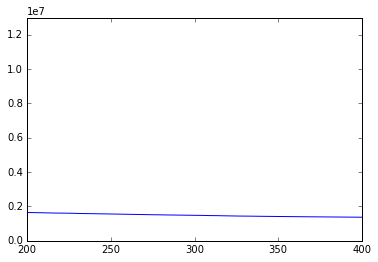

In [179]:
plt.plot(list(output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["cumulative_downloads_2016-02"]))
plt.axis([200, 400, 0, 13000000])

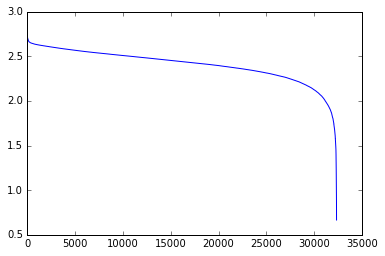

In [127]:
plt.plot(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"]))


In [242]:
output

,Unnamed: 0,id,name,category,device,cumulative_downloads_2016-02
0,0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,753496
1,1,281922769,Mobile MIM,Medical,ipad,100804
2,2,281922769,Mobile MIM,Medical,iphone,111613
3,3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,370383
4,4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,1330247
5,5,284147312,iTrans DC Metro,Navigation,iphone,886720
6,6,284574017,Units - Free Unit Converter,Utilities,ipad,194504
7,7,284574017,Units - Free Unit Converter,Utilities,iphone,337464
8,8,284735786,Compass Free,Utilities,ipad,122824
9,9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,642


In [9]:
predictors

,id,name,category,device,week_1,week_2,week_3,week_4,week_5,week_6,...,m4_coef_0,m4_coef_1,m4_coef_2,rev_coef_0,rev_max,rev_min,rev_mean,rev_std,rev_coef_1,rev_coef_2
0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,6.239161,6.127804,6.101279,6.183265,6.078625,5.926926,...,88130.375000,-2675.898810,549.422619,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1,281922769,Mobile MIM,Medical,ipad,4.075113,4.084775,3.964886,4.198275,4.089571,4.027899,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,281922769,Mobile MIM,Medical,iphone,4.576183,4.532599,4.418841,4.507715,4.480578,4.464265,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,5.617810,5.557379,5.520317,5.371302,5.493649,5.418637,...,350810.583333,-516.928571,-141.119048,415.328688,0.0,0.0,0.0,0.0,-0.732351,-0.035426
4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,7.038282,7.073875,7.173192,7.016097,7.020318,7.022613,...,350810.583333,-516.928571,-141.119048,4691.119653,0.0,0.0,0.0,0.0,195.635228,-4.040557
5,284147312,iTrans DC Metro,Navigation,iphone,6.340107,6.486814,6.627474,6.550468,6.656359,6.727432,...,50938.416667,8472.071429,-861.452381,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
6,284574017,Units - Free Unit Converter,Utilities,ipad,4.513994,4.163337,4.129436,4.223701,4.169982,4.313671,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
7,284574017,Units - Free Unit Converter,Utilities,iphone,6.052089,5.997695,6.167516,6.042633,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
8,284735786,Compass Free,Utilities,ipad,3.579543,3.695997,3.797093,3.925268,3.909162,3.703064,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [25]:
predictors.sort_values(by= 'week_8',ascending = False)[0:3233].head(3)

,id,name,category,device,week_1,week_2,week_3,week_4,week_5,week_6,...,m4_coef_0,m4_coef_1,m4_coef_2,rev_coef_0,rev_max,rev_min,rev_mean,rev_std,rev_coef_1,rev_coef_2
27588,883125430,Insta3D - Create Your Own 3D Avatar | Animate ...,Lifestyle,iphone,6.324359,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17864,627874917,影视大全-大片热剧免费看,Entertainment,iphone,8.410753,8.802480,9.088027,9.274964,9.105361,9.346169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24133,789653936,KuaidiONE,Travel,iphone,8.724741,8.363676,8.832192,9.247030,9.026263,9.542938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)[0:323].head(3)

,Unnamed: 0,id,name,category,device,cumulative_downloads_2016-02
29477,29477,911686788,"百度外卖-美食,优惠,水果生鲜,鲜花蛋糕,超市购",Food and Drink,iphone,12329752
17864,17864,627874917,影视大全-大片热剧免费看,Entertainment,iphone,7500310
30102,30102,921478733,"嘀嗒拼车-创新1对1拼车,天天出行顺风车",Travel,iphone,6928800


In [30]:
len(predictors.sort_values(by= 'week_8',ascending = False)[0:3233].merge(output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)[0:323], how='inner', on=["id","name","category","device"]))

313

In [32]:
313.0/323

0.9690402476780186